# Imports

In [1]:
import os

from verification_system import VerificationSystem

# Testing Single Users

In [2]:
verification_system = VerificationSystem(
    database_path=os.path.join("data", "database"),
)

24-04-08 08:54:53 - Searching data\database\incoming_users\authorized_users\1\000023.jpg in 1840 length datastore
24-04-08 08:54:55 - find function duration 5.519145965576172 seconds


### Previously verified user

In [3]:
verification_system.verify_user(
    user_name="1",
    user_photo_path=verification_system.get_incoming_authorized_user_path(),
)

(True,
 0    0.330863
 1    0.373292
 2    0.391256
 3    0.424649
 Name: distance, dtype: float64)

### Not authorized user

In [4]:
verification_system.verify_user(
    user_name="101",
    user_photo_path=verification_system.get_incoming_unauthorized_user_path(),
)

(False, inf)

### No face detected or above acceptance threshold

In [5]:
verification_system.verify_user(
    user_name="22",
    user_photo_path=verification_system.get_problematic_incoming_authorized_user_path(),
)

(False, inf)

# Testing Multiple Users

### Incoming Authorized Users

In [6]:
df_incoming_authorized_users = verification_system.verify_multiple_users(
    incoming_users_path=os.path.join(
        "data", "database", "incoming_users", "authorized_users"
    ),
)

Processing users:   0%|          | 0/50 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/2 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/2 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/2 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_incoming_authorized_users.head()

,image_path,is_access_granted,distance
0,data\database\incoming_users\authorized_users\...,True,0.330863
1,data\database\incoming_users\authorized_users\...,False,inf
2,data\database\incoming_users\authorized_users\...,True,0.374353
3,data\database\incoming_users\authorized_users\...,True,0.476245
4,data\database\incoming_users\authorized_users\...,True,0.374931


In [8]:
verification_system.calculate_access_granted_rate(df_users=df_incoming_authorized_users)

0.8341708542713567

### Incoming Unauthorized Users

In [9]:
df_incoming_unauthorized_users = verification_system.verify_multiple_users(
    incoming_users_path=os.path.join(
        "data", "database", "incoming_users", "unauthorized_users"
    ),
)

Processing users:   0%|          | 0/50 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/2 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/2 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/4 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/6 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/5 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/1 [00:00<?, ?it/s]

Processing user photos:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
df_incoming_unauthorized_users.head()

,image_path,is_access_granted,distance
0,data\database\incoming_users\unauthorized_user...,False,inf
1,data\database\incoming_users\unauthorized_user...,False,inf
2,data\database\incoming_users\unauthorized_user...,False,inf
3,data\database\incoming_users\unauthorized_user...,False,inf
4,data\database\incoming_users\unauthorized_user...,False,inf


In [11]:
verification_system.calculate_access_granted_rate(
    df_users=df_incoming_unauthorized_users
)

0.0

### Calculate FRR and FRR

In [12]:
far, frr = verification_system.calculate_far_frr(
    df_users_authorized=df_incoming_authorized_users,
    df_users_unauthorized=df_incoming_unauthorized_users,
)
print(f"FAR == {far}, FRR == {frr}")

FAR == 0.16582914572864327, FRR == 0.0


### Plot ROC curve

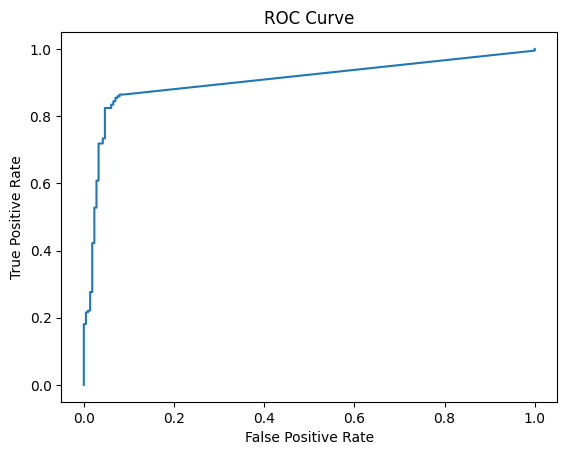

(214, 0, 33, 166)

In [13]:
verification_system.draw_ROC_curve(
    df_users_authorized=df_incoming_authorized_users,
    df_users_unauthorized=df_incoming_unauthorized_users,
)